In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import inspect
import os
import sys
import time

from copy import deepcopy

np.random.seed(42) # nothing special about this seed (we hope)!

In [2]:
import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

In [33]:
reg_params = dict()
datafile = 'fits/transformed_gene_regression_df7_degree3_genes1000.npz'
with np.load(datafile) as infile:
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    df = infile['df']
    degree = infile['degree']
    
num_genes = reg_params['beta_mean'].shape[0]
obs_dim = reg_params['beta_mean'].shape[1]

num_components = 30

analysis_name = 'transformed_gene_regression_df{}_degree{}_genes{}_num_components{}_fit'.format(
    df, degree, num_genes, num_components)
print(reg_params['beta_info'].shape, reg_params['beta_mean'].shape)

(700, 9, 9) (700, 9)


In [39]:
prior_params = gmm_lib.get_base_prior_params(obs_dim, num_components)
prior_params_pattern = gmm_lib.get_prior_params_pattern(obs_dim, num_components)
prior_params_pattern.validate_folded(prior_params)
gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

In [16]:
print('Running k-means init.')
kmeans_params = \
    gmm_lib.kmeans_init(gmm.reg_params,
                        gmm.num_components, 50)
print('Done.')
init_gmm_params = dict()
init_gmm_params['centroids'] = kmeans_params['centroids']
init_gmm_params['stick_propn_mean'] = np.zeros(gmm.num_components - 1)
init_gmm_params['stick_propn_info'] = np.ones(gmm.num_components - 1)

init_x = gmm.gmm_params_pattern.flatten(init_gmm_params, free=True)

Running k-means init.
Done.


In [18]:
gmm.conditioned_obj.reset() # Reset the logging and iteration count.
gmm.conditioned_obj.set_print_every(1)

opt_time = time.time()
gmm_opt, init_x2 = gmm.optimize(init_x, gtol=1e-2)
opt_time = time.time() - opt_time

Iter 0: f = -109917.64050961
Iter 1: f = -110768.57000446
Iter 2: f = -111873.44728260
Iter 3: f = -112849.66599541
Iter 4: f = -113347.60868840
Iter 5: f = -113986.70391328
Iter 6: f = -112823.78267108
Iter 7: f = -114293.35008670
Iter 8: f = -113045.49006602
Iter 9: f = -114365.44781672
Iter 10: f = -114444.68561335
Iter 11: f = -114488.86308943
Iter 12: f = -114549.54084154
Iter 13: f = -113949.47358034
Iter 14: f = -114593.62233665
Iter 15: f = -114609.26615717
Iter 16: f = -114612.72387499
Iter 17: f = -114617.22829599
Iter 18: f = -114626.05052539
Iter 19: f = -114635.26519052
Iter 20: f = -114644.04299243
Iter 21: f = -114647.70750669
Iter 22: f = -114661.74357380
Iter 23: f = -114664.10969925
Iter 24: f = -114671.61533685
Iter 25: f = -114472.56893862
Iter 26: f = -114676.56238539
Iter 27: f = -114678.00260802
Iter 28: f = -114682.27449244
Iter 29: f = -114683.53430610
Iter 30: f = -114684.69031755
Iter 31: f = -114685.83628810
Iter 32: f = -114686.36909975
Iter 33: f = -114688

In [19]:
tic = time.time()
# Note that h_cond is the Hessian.
h_cond = gmm.update_preconditioner(init_x2)
opt_time += time.time() - tic

In [20]:
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x2, verbose=True)
opt_time += time.time() - tic
print('Optimization time: {} seconds'.format(opt_time))

Preconditioned iteration 1
  Running preconditioned optimization.
Iter 0: f = -114708.82062376
Iter 1: f = -114708.82062384
Preconditioned iteration 2
  Getting Hessian and preconditioner.
  Running preconditioned optimization.
Iter 2: f = -114708.82062384
Converged.
Optimization time: 113.52060985565186 seconds


In [23]:
opt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
print(opt_gmm_params.keys())
e_z = gmm.get_e_z(opt_gmm_params)
print(np.sort(np.mean(e_z, axis=0)))

odict_keys(['centroids', 'stick_propn_mean', 'stick_propn_info'])
[0.00142799 0.00285714 0.0048516  0.00857864 0.00999151 0.00999739
 0.01154634 0.01430391 0.01571111 0.01857141 0.02001583 0.022665
 0.02431428 0.02469352 0.02793206 0.02828265 0.02899212 0.03085765
 0.03288252 0.03480003 0.03843064 0.03980744 0.04236644 0.04748914
 0.05154199 0.05210717 0.05285055 0.06095989 0.07030525 0.17086878]


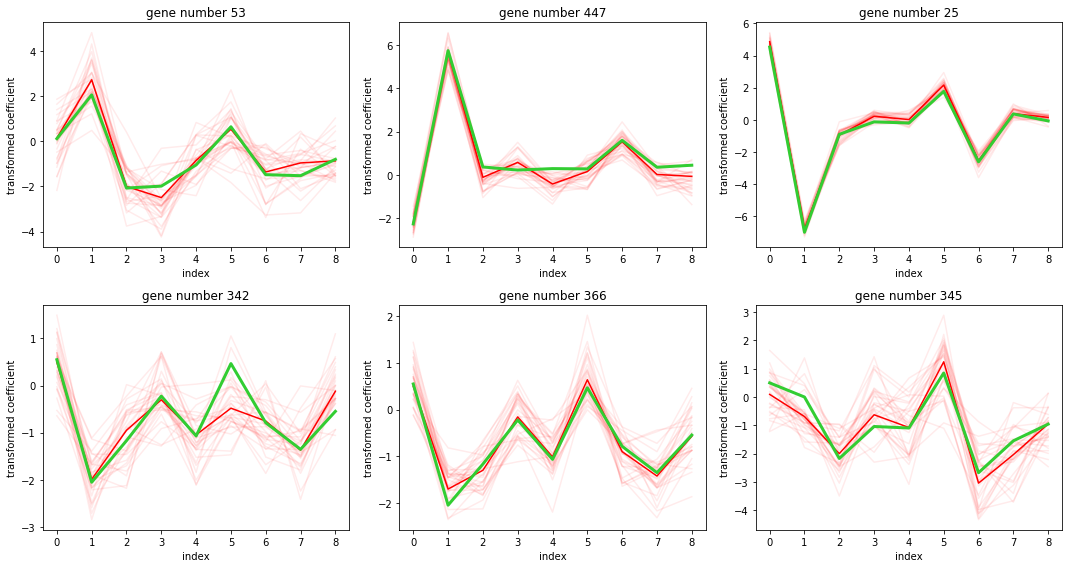

In [24]:
# Sanity check with a figure

f, axarr = plt.subplots(2, 3, figsize=(15,8))

plot_inds = np.random.choice(gmm.num_obs, 6, replace=False)
for i in range(6):
    n = plot_inds[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))

        axarr[int(np.floor(i / 3)), i % 3].plot(
            transformed_beta_draw, color = 'red', alpha = 0.08);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);

f.tight_layout()

In [41]:
save_dict = deepcopy(gmm_opt)
save_dict['df'] = df
save_dict['degree'] = degree
save_dict['datafile'] = datafile
save_dict['num_components'] = num_components
save_dict['opt_gmm_params'] = opt_gmm_params
save_dict['prior_params_pattern_json'] = \
    prior_params_pattern.to_json()
save_dict['prior_params'] = \
    prior_params_pattern.flatten(prior_params, free=False)

outfile = './fits/{}.npz'.format(analysis_name)
print('Saving to {}'.format(outfile))

np.savez_compressed(file=outfile, **save_dict)

Saving to ./fits/transformed_gene_regression_df7_degree3_genes700_num_components30_fit.npz
